### Compare model output with a station (precipitation)

In [1]:
# libs
import xarray as xr
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


# not using this one, but it is useful when multiple stations
#from scipy.spatial import cKDTree

In [2]:
mp9_bl8_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl8/'
mp9_bl2_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl2/'


mp9_bl8_files = sorted(glob.glob(mp9_bl8_path+"wrfout_d02*"))
mp9_bl2_files = sorted(glob.glob(mp9_bl2_path+"wrfout_d02*"))


In [3]:
ds_mp9_bl8 = xr.open_mfdataset(mp9_bl8_files, combine='nested', concat_dim='Time')
ds_mp9_bl2 = xr.open_mfdataset(mp9_bl2_files, combine='nested', concat_dim='Time')


In [4]:
# obtain indexes of model grid closest to station
lat = ds_mp9_bl2['XLAT'].isel(Time=0)  # (south_north, west_east)
lon = ds_mp9_bl2['XLONG'].isel(Time=0)

# coords of station LAYTONVILLE
sta_lat = 39.702330
sta_lon = -123.484910

# Compute distance (squared) to every grid point
dist_sq = (lat - sta_lat)**2 + (lon - sta_lon)**2

In [5]:
# get the indexes lat, lon of the closest grid
iy, ix = np.unravel_index(np.argmin(dist_sq.values), dist_sq.shape)

# get the indexes lat, lon of the closest 4 grids
iy4, ix4 = np.unravel_index(np.argpartition(dist_sq.values.flatten(), 4)[:4], dist_sq.shape)


In [6]:
print(iy,ix)

189 184


In [6]:
# distances
dist_sq.values.flatten()[np.argpartition(dist_sq.values.flatten(), 4)][:4]

array([0.01213316, 0.00928977, 0.00566094, 0.00083109], dtype=float32)

In [7]:
# print coordinate of the closest grid in the model 
print(f"Model lon of closest grid: {lon[iy, ix].values}")
print(f"Model lat of closest grid: {lat[iy, ix].values}")

Model lon of closest grid: -123.50617980957031
Model lat of closest grid: 39.7217903137207


In [8]:
for i in range(len(ix4)):
    print(f"Model lon of {len(ix4)-i} closest grid: {lon[iy4[i], ix4[i]].values}")
    print(f"Model lat of {len(ix4)-i} closest grid: {lat[iy4[i], ix4[i]].values}")

Model lon of 4 closest grid: -123.50027465820312
Model lat of 4 closest grid: 39.811405181884766
Model lon of 3 closest grid: -123.38967895507812
Model lat of 3 closest grid: 39.71719741821289
Model lon of 2 closest grid: -123.5120849609375
Model lat of 2 closest grid: 39.632171630859375
Model lon of 1 closest grid: -123.50617980957031
Model lat of 1 closest grid: 39.7217903137207


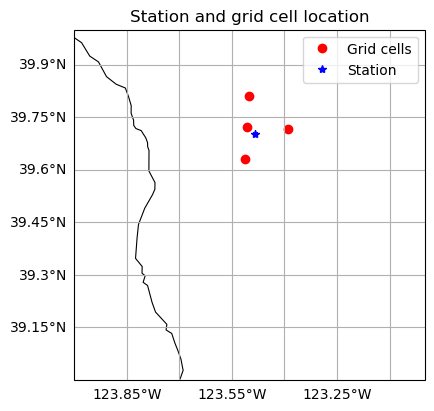

In [9]:
## map of points and stations

# bounding box limits
lon_min = -124
lon_max = -123
lat_min = 39
lat_max = 40


# make lists of lat lon
wrf_lons = []
wrf_lats = []
for i in range(len(ix4)):
    wrf_lons.append(lon[iy4[i], ix4[i]].values)
    wrf_lats.append(lat[iy4[i], ix4[i]].values)



# a Lambert projection using ref lat and lon from namelist.wps
projection = ccrs.PlateCarree()

fig, ax = plt.subplots(
    figsize=(8, 4), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)

## bounding box limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max]) 

# add coastline, states and borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)


## 
plt.plot(wrf_lons, wrf_lats, 'ro', transform=ccrs.PlateCarree(),label='Grid cells')
plt.plot(sta_lon, sta_lat, 'b*', transform=ccrs.PlateCarree(),label='Station')

grid = ax.gridlines(draw_labels=True)
grid.right_labels = False
grid.top_labels = False

plt.legend()

plt.title('Station and grid cell location')

plt.show()

In [10]:
# add convective and parameterized precip
pr_mp9_bl2 = ds_mp9_bl2['RAINNC'] +\
             ds_mp9_bl2['RAINC']

pr_mp9_bl8 = ds_mp9_bl8['RAINNC'] +\
             ds_mp9_bl8['RAINC']

In [11]:
pr_mp9_bl2_ts = pr_mp9_bl2.isel(south_north=iy, west_east=ix).values

In [12]:
pr_mp9_bl8_ts = pr_mp9_bl8.isel(south_north=iy, west_east=ix).values

In [13]:
times = pr_mp9_bl8['XTIME'].values

In [14]:
df_pr = pd.DataFrame({'Date': times, 'PBL8': pr_mp9_bl8_ts, 'PBL2': pr_mp9_bl2_ts})
df_pr['Date'] = pd.to_datetime(df_pr['Date']).dt.tz_localize(None)

In [15]:
df_pr['Date']

0     2024-11-18 12:00:00
1     2024-11-18 13:00:00
2     2024-11-18 14:00:00
3     2024-11-18 15:00:00
4     2024-11-18 16:00:00
              ...        
140   2024-11-24 08:00:00
141   2024-11-24 09:00:00
142   2024-11-24 10:00:00
143   2024-11-24 11:00:00
144   2024-11-24 12:00:00
Name: Date, Length: 145, dtype: datetime64[ns]

<Axes: xlabel='Date'>

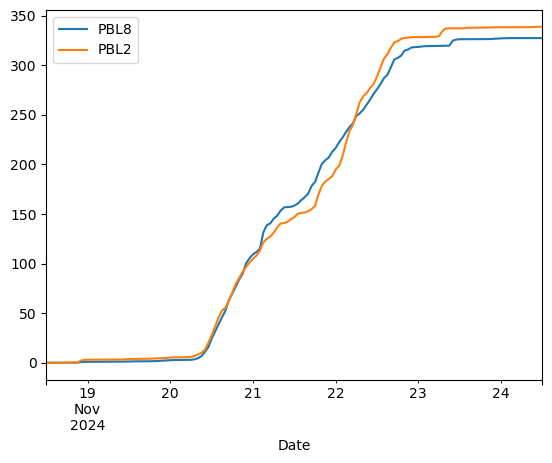

In [16]:
df_pr.plot(x='Date')

In [17]:
sites_path = '/glade/u/home/jhenao/atm746/data_precip/monitoring_sites/'  # replace with your actual file path

site = 'LAYC1'

df = pd.read_csv(
    sites_path+site+'.2024-11-24.csv',
    comment='#'
)
# Drop the first row (units) and reset the index
df = df.drop(0).reset_index(drop=True)


df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')
df['precip_accum_set_1'] = pd.to_numeric(df['precip_accum_set_1'].str.strip(), errors='coerce')


In [18]:
prec_obs = df['precip_accum_set_1'] - df['precip_accum_set_1'][0]

In [19]:
df_obs = pd.DataFrame({'Date': df['Date_Time'], 'LAYC1': prec_obs})
df_obs['Date'] = pd.to_datetime(df_obs['Date']).dt.tz_localize(None)
df_obs['Date']

0     2024-11-18 12:29:00
1     2024-11-18 13:29:00
2     2024-11-18 14:29:00
3     2024-11-18 15:29:00
4     2024-11-18 16:29:00
              ...        
139   2024-11-24 07:29:00
140   2024-11-24 08:29:00
141   2024-11-24 09:29:00
142   2024-11-24 10:29:00
143   2024-11-24 11:29:00
Name: Date, Length: 144, dtype: datetime64[ns]

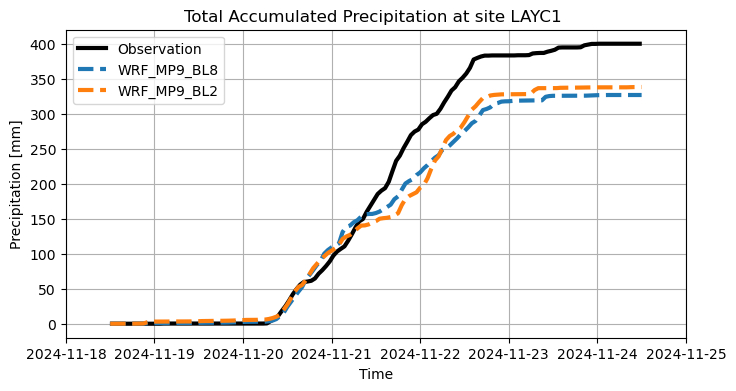

In [20]:

plt.figure(figsize=(8, 4))

plt.xlim(pd.Timestamp("2024-11-18"), pd.Timestamp("2024-11-25"))

# from station
plt.plot(df_obs['Date'], prec_obs, label="Observation", linewidth=3, color='black')
# from wrf
plt.plot(df_pr['Date'], df_pr['PBL8'], label="WRF_MP9_BL8", linewidth=3, linestyle='--')
plt.plot(df_pr['Date'], df_pr['PBL2'], label="WRF_MP9_BL2", linewidth=3, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.title(f"Total Accumulated Precipitation at site {site} ")

plt.legend()

plt.grid(True)



In [21]:


series_list = []

# Loop over the 4 closest grid points
for y, x in zip(iy4, ix4):
    ts = pr_mp9_bl8.isel(south_north=y, west_east=x)
    series_list.append(ts.values)

series_array = np.stack(series_list, axis=1)

In [22]:
series_array

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.78222147e-04, 5.15668793e-03, 4.70112078e-04, 9.74828319e-04],
       [3.33870272e-03, 9.12384316e-03, 3.47396685e-03, 4.15646704e-03],
       [5.32345008e-03, 1.03860553e-02, 3.84392426e-03, 5.53216692e-03],
       [5.32345008e-03, 1.23215141e-02, 3.84392426e-03, 5.53330546e-03],
       [5.63094625e-03, 1.46421473e-02, 4.92915511e-03, 9.02162399e-03],
       [1.08968979e-02, 4.20697480e-02, 1.98719334e-02, 1.57554708e-02],
       [1.08554572e-01, 7.33382106e-02, 2.91212332e-02, 1.98120754e-02],
       [2.37876967e-01, 1.16589442e-01, 5.88047244e-02, 5.07652536e-02],
       [3.36032242e-01, 2.00917706e-01, 1.38340130e-01, 1.53513402e-01],
       [4.80424047e-01, 2.57372826e-01, 5.29453635e-01, 6.20988905e-01],
       [5.34752905e-01, 4.08893138e-01, 1.98893118e+00, 8.63848567e-01],
       [5.57301342e-01, 4.18931633e-01, 1.99121475e+00, 8.78982127e-01],
       [5.58179021e-01, 4.18993622e-01, 1.99121475e

In [23]:
# create a pandas dataframe
df_4pts = pd.DataFrame(
    data=series_array,
    index=df_pr['Date'],
    columns=[f'grid_{i}' for i in range(len(ix4))]
)


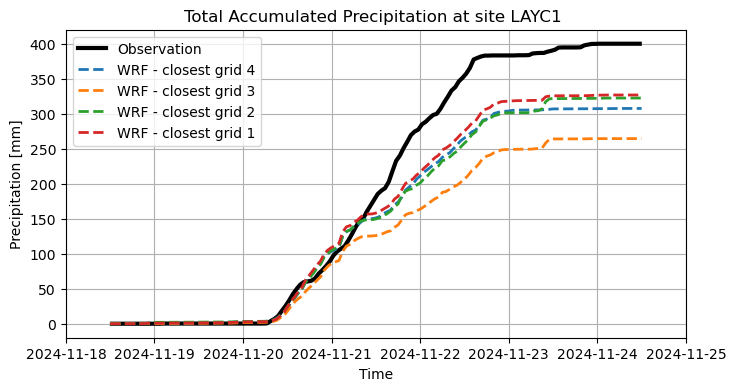

In [24]:
plt.figure(figsize=(8, 4))

plt.xlim(pd.Timestamp("2024-11-18"), pd.Timestamp("2024-11-25"))

# from station
plt.plot(df_obs['Date'],prec_obs, label="Observation", linewidth=3, color='black')
# from wrf
for i in range(len(ix4)):
    plt.plot(df_pr['Date'], df_4pts[f'grid_{i}'], label=f'WRF - closest grid {len(ix4) - i}', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.title(f"Total Accumulated Precipitation at site {site} ")

plt.legend()

plt.grid(True)